In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


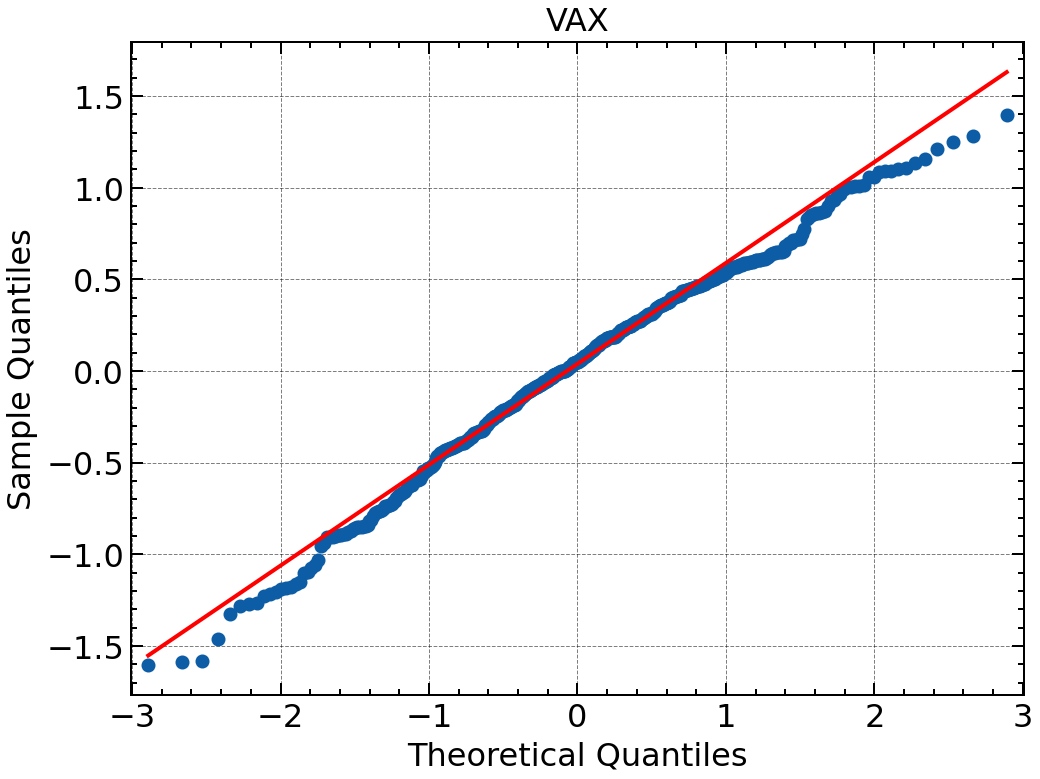

In [30]:
# QQ plots
from scipy.stats import norm, uniform
from statsmodels.graphics.gofplots import qqplot

# asset pseudo_observations
ieac_obs = pd.read_csv('../database/pseudo_observations/VAS.txt')
ieac_obs  = np.array(ieac_obs.iloc[::2, :])
ieac_obs = norm.ppf(np.array([float(i[0]) for i in ieac_obs]),0, 1)
qqplot(ieac_obs, norm, fit=False, line='q')
plt.title("VAX")
plt.savefig('testing.eps')
plt.show()


In [38]:
# Vol plots
from database.database_parser import create_connection
from database.database_parser import select_curr_solution
from database.database_parser import select_price_data
test_connection = create_connection('../database/abacus_database.db')

def generate_volatility(params, data):
    n_observations = len(data)
    initial_squared_vol_estimate = (params[0]
                                        + params[1] * (data[0] ** 2)
                                        + params[3] * (data[0] ** 2) * np.where(data[0] < 0, 1, 0)
                                        + params[2] * (data[0] ** 2))
    current_squared_vol_estimate = initial_squared_vol_estimate

    for i in range(0, n_observations):
        current_squared_vol_estimate = (params[0] + params[1] * (data[i - 1] ** 2)
                                            + params[3] * (data[i - 1] ** 2) * np.where(data[i - 1] < 0, 1, 0)
                                            + params[2] * current_squared_vol_estimate)

    return np.sqrt(current_squared_vol_estimate)

def get_volatility(asset: str):
    opt_sol = select_curr_solution(test_connection, asset)
    adj_close = select_price_data(test_connection, asset)
    print(adj_close)
    log_returns = np.array(np.log(adj_close / adj_close.shift(1))[1:])
    return generate_volatility(params=opt_sol, data=log_returns)

In [4]:
# Return plots